# Machine Learning-Based Video Encoding Performance Prediction for AV1 Codec


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the datasets
print("Loading datasets...")
df_train = pd.read_csv('/kaggle/input/final-encoding-dataset/train.csv')  # Replace with your train dataset path
df_test_separate = pd.read_csv('/kaggle/input/final-encoding-dataset/test.csv')  # Replace with your test dataset path

print("Training Dataset Overview:")
print(f"Shape: {df_train.shape}")
print("\nSeparate Test Dataset Overview:")
print(f"Shape: {df_test_separate.shape}")
print("\nTraining Dataset Info:")
print(df_train.info())
print("\nTraining Dataset First 5 rows:")
print(df_train.head())
print("\nTraining Dataset Missing values:")
print(df_train.isnull().sum())
print("\nTraining Dataset Statistical Summary:")
print(df_train.describe())

Loading datasets...
Training Dataset Overview:
Shape: (10615, 13)

Separate Test Dataset Overview:
Shape: (2648, 13)

Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10615 entries, 0 to 10614
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Input                10615 non-null  object 
 1   Resolution           10615 non-null  object 
 2   FPS                  10615 non-null  float64
 3   Rate Ctrl            10615 non-null  int64  
 4   Bitrate              10615 non-null  int64  
 5   QP                   10615 non-null  int64  
 6   Preset               10615 non-null  int64  
 7   Tune                 10615 non-null  object 
 8   Enc FPS              10541 non-null  float64
 9   Y-PSNR               10543 non-null  float64
 10  CPU                  10615 non-null  int64  
 11  RAM                  10615 non-null  object 
 12  CPU Max Clock Speed  10615 non-null  object 


# DATA PREPROCESSING

In [3]:

# ============================================================================
# DATA PREPROCESSING
# ============================================================================

def preprocess_data(df_train, df_test_separate=None):
    """
    Comprehensive data preprocessing pipeline for both training and test datasets
    """
    print("\n=== DATA PREPROCESSING ===")
    
    # Create copies to avoid modifying original data
    df_train_processed = df_train.copy()
    df_test_processed = df_test_separate.copy() if df_test_separate is not None else None
    
    # Drop unnecessary columns
    print("Dropping unnecessary columns...")
    columns_to_drop = ['Input'] if 'Input' in df_train_processed.columns else []
    
    if columns_to_drop:
        df_train_processed = df_train_processed.drop(columns=columns_to_drop)
        if df_test_processed is not None:
            df_test_processed = df_test_processed.drop(columns=columns_to_drop, errors='ignore')
        print(f"Dropped columns: {columns_to_drop}")
    
    # Parse CPU Max Clock Speed to numeric (GHz)
    print("Converting CPU Max Clock Speed to numeric format...")
    if 'CPU Max Clock Speed' in df_train_processed.columns:
        df_train_processed['CPU_Clock_GHz'] = df_train_processed['CPU Max Clock Speed'].str.replace('GHz', '').astype(float)
        df_train_processed = df_train_processed.drop('CPU Max Clock Speed', axis=1)
        
        if df_test_processed is not None and 'CPU Max Clock Speed' in df_test_processed.columns:
            df_test_processed['CPU_Clock_GHz'] = df_test_processed['CPU Max Clock Speed'].str.replace('GHz', '').astype(float)
            df_test_processed = df_test_processed.drop('CPU Max Clock Speed', axis=1)
    
    # Handle missing values in target variables
    print(f"\nHandling missing values...")
    
    # For training data
    if 'Enc FPS' in df_train_processed.columns:
        train_enc_fps_median = df_train_processed['Enc FPS'].median()
        print(f"Training - Missing values in Enc FPS: {df_train_processed['Enc FPS'].isnull().sum()}")
        df_train_processed['Enc FPS'].fillna(train_enc_fps_median, inplace=True)
        
        # Use training median for test data too
        if df_test_processed is not None and 'Enc FPS' in df_test_processed.columns:
            print(f"Test - Missing values in Enc FPS: {df_test_processed['Enc FPS'].isnull().sum()}")
            df_test_processed['Enc FPS'].fillna(train_enc_fps_median, inplace=True)
    
    if 'Y-PSNR' in df_train_processed.columns:
        train_psnr_median = df_train_processed['Y-PSNR'].median()
        print(f"Training - Missing values in Y-PSNR: {df_train_processed['Y-PSNR'].isnull().sum()}")
        df_train_processed['Y-PSNR'].fillna(train_psnr_median, inplace=True)
        
        # Use training median for test data too
        if df_test_processed is not None and 'Y-PSNR' in df_test_processed.columns:
            print(f"Test - Missing values in Y-PSNR: {df_test_processed['Y-PSNR'].isnull().sum()}")
            df_test_processed['Y-PSNR'].fillna(train_psnr_median, inplace=True)
    
    # Parse Resolution to extract width and height
    print("\nExtracting resolution features...")
    if 'Resolution' in df_train_processed.columns:
        df_train_processed[['Width', 'Height']] = df_train_processed['Resolution'].str.split('x', expand=True)
        df_train_processed['Width'] = df_train_processed['Width'].astype(int)
        df_train_processed['Height'] = df_train_processed['Height'].astype(int)
        df_train_processed['Total_Pixels'] = df_train_processed['Width'] * df_train_processed['Height']
        df_train_processed = df_train_processed.drop('Resolution', axis=1)
        
        if df_test_processed is not None and 'Resolution' in df_test_processed.columns:
            df_test_processed[['Width', 'Height']] = df_test_processed['Resolution'].str.split('x', expand=True)
            df_test_processed['Width'] = df_test_processed['Width'].astype(int)
            df_test_processed['Height'] = df_test_processed['Height'].astype(int)
            df_test_processed['Total_Pixels'] = df_test_processed['Width'] * df_test_processed['Height']
            df_test_processed = df_test_processed.drop('Resolution', axis=1)
    
    # Parse RAM to extract numeric value in KB
    print("Converting RAM to numeric format...")
    if 'RAM' in df_train_processed.columns:
        df_train_processed['RAM_KB'] = df_train_processed['RAM'].str.replace('KB', '').astype(int)
        df_train_processed = df_train_processed.drop('RAM', axis=1)
        
        if df_test_processed is not None and 'RAM' in df_test_processed.columns:
            df_test_processed['RAM_KB'] = df_test_processed['RAM'].str.replace('KB', '').astype(int)
            df_test_processed = df_test_processed.drop('RAM', axis=1)
    
    # Encode categorical variables - FIT ON TRAINING DATA ONLY
    print("Encoding categorical variables...")
    le_tune = LabelEncoder()
    
    if 'Tune' in df_train_processed.columns:
        df_train_processed['Tune_Encoded'] = le_tune.fit_transform(df_train_processed['Tune'])
        df_train_processed = df_train_processed.drop('Tune', axis=1)
        
        if df_test_processed is not None and 'Tune' in df_test_processed.columns:
            # Handle unseen categories in test data
            df_test_processed['Tune_Encoded'] = df_test_processed['Tune'].apply(
                lambda x: le_tune.transform([x])[0] if x in le_tune.classes_ else -1
            )
            df_test_processed = df_test_processed.drop('Tune', axis=1)
    
    # Handle Rate Control and QP/Bitrate relationship
    print("Engineering rate control features...")
    for df in [df_train_processed] + ([df_test_processed] if df_test_processed is not None else []):
        df['Uses_QP'] = (df['Rate Ctrl'] == 0).astype(int)
        df['Uses_Bitrate'] = (df['Rate Ctrl'] > 0).astype(int)
        df['QP_Clean'] = df['QP'].replace(-1, 0)
        df['Bitrate_Clean'] = df['Bitrate'].replace(-1, 0)
    
    print(f"Training processed dataset shape: {df_train_processed.shape}")
    if df_test_processed is not None:
        print(f"Test processed dataset shape: {df_test_processed.shape}")
    print(f"Tune categories: {le_tune.classes_}")
    
    return df_train_processed, df_test_processed, le_tune




# FEATURE ENGINEERING

In [4]:
# ============================================================================
# FEATURE ENGINEERING
# ============================================================================

def engineer_features(df_train, df_test=None):
    """
    Advanced feature engineering for video encoding performance
    """
    print("\n=== FEATURE ENGINEERING ===")
    
    def add_features(df):
        df_features = df.copy()
        
        # Video complexity features
        df_features['Video_Complexity'] = df_features['Total_Pixels'] * df_features['FPS']
        df_features['Aspect_Ratio'] = df_features['Width'] / df_features['Height']
        
        # Encoding intensity features
        df_features['QP_Intensity'] = df_features['QP_Clean'] * df_features['Uses_QP']
        df_features['Bitrate_Intensity'] = df_features['Bitrate_Clean'] * df_features['Uses_Bitrate']
        
        # Preset efficiency (higher preset = faster encoding)
        df_features['Preset_Efficiency'] = 11 - df_features['Preset']
        
        # Quality vs Speed trade-off
        df_features['Quality_Speed_Ratio'] = df_features['Y-PSNR'] / (df_features['Enc FPS'] + 1e-6)
        
        # Computational load estimation
        df_features['Computational_Load'] = (df_features['Video_Complexity'] / 1000000) * (df_features['Preset_Efficiency'])
        
        # CPU performance scaling features
        df_features['CPU_Performance_Index'] = df_features['CPU_Clock_GHz'] * 1000
        df_features['Performance_Per_Pixel'] = df_features['CPU_Clock_GHz'] / (df_features['Total_Pixels'] / 1000000)
        
        # Hardware-adjusted computational load
        df_features['Hardware_Adjusted_Load'] = df_features['Computational_Load'] / df_features['CPU_Clock_GHz']
        
        return df_features
    
    df_train_features = add_features(df_train)
    df_test_features = add_features(df_test) if df_test is not None else None
    
    print(f"Added {len(df_train_features.columns) - len(df_train.columns)} new features")
    print("New features created:")
    new_features = [col for col in df_train_features.columns if col not in df_train.columns]
    for feature in new_features:
        print(f"  - {feature}")
    
    return df_train_features, df_test_features

# EXPLORATORY DATA ANALYSIS


In [5]:
# ============================================================================
# EXPLORATORY DATA ANALYSIS
# ============================================================================

def perform_eda(df_train, df_test=None):
    """
    Comprehensive exploratory data analysis with visualizations
    """
    print("\n=== EXPLORATORY DATA ANALYSIS ===")
    
    # Set up the plotting style
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 20))
    
    # Create subplots for training data
    datasets = [('Training', df_train)]
    if df_test is not None:
        datasets.append(('Test', df_test))
    
    for dataset_idx, (dataset_name, df) in enumerate(datasets):
        base_subplot = dataset_idx * 12
        
        # 1. Distribution of target variables
        plt.subplot(len(datasets) * 3, 4, base_subplot + 1)
        plt.hist(df['CPU'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title(f'{dataset_name} - CPU Usage Distribution')
        plt.xlabel('CPU Usage (%)')
        plt.ylabel('Frequency')
        
        plt.subplot(len(datasets) * 3, 4, base_subplot + 2)
        plt.hist(df['Enc FPS'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
        plt.title(f'{dataset_name} - Encoding FPS Distribution')
        plt.xlabel('Encoding FPS')
        plt.ylabel('Frequency')
        
        plt.subplot(len(datasets) * 3, 4, base_subplot + 3)
        plt.hist(df['RAM_KB'], bins=30, alpha=0.7, color='salmon', edgecolor='black')
        plt.title(f'{dataset_name} - RAM Usage Distribution')
        plt.xlabel('RAM Usage (KB)')
        plt.ylabel('Frequency')
        
        # 2. Feature relationships
        plt.subplot(len(datasets) * 3, 4, base_subplot + 4)
        plt.scatter(df['Preset'], df['Enc FPS'], alpha=0.6, color='purple')
        plt.title(f'{dataset_name} - Preset vs Encoding FPS')
        plt.xlabel('Preset')
        plt.ylabel('Encoding FPS')
        
        plt.subplot(len(datasets) * 3, 4, base_subplot + 5)
        qp_data = df[df['Uses_QP']==1]
        if len(qp_data) > 0:
            plt.scatter(qp_data['QP_Clean'], qp_data['Enc FPS'], alpha=0.6, color='orange')
        plt.title(f'{dataset_name} - QP vs Encoding FPS')
        plt.xlabel('QP Value')
        plt.ylabel('Encoding FPS')
        
        plt.subplot(len(datasets) * 3, 4, base_subplot + 6)
        bitrate_data = df[df['Uses_Bitrate']==1]
        if len(bitrate_data) > 0:
            plt.scatter(bitrate_data['Bitrate_Clean'], bitrate_data['Enc FPS'], alpha=0.6, color='red')
        plt.title(f'{dataset_name} - Bitrate vs Encoding FPS')
        plt.xlabel('Bitrate (kbps)')
        plt.ylabel('Encoding FPS')
        
        plt.subplot(len(datasets) * 3, 4, base_subplot + 7)
        plt.scatter(df['Total_Pixels'], df['Enc FPS'], alpha=0.6, color='brown')
        plt.title(f'{dataset_name} - Resolution vs Encoding FPS')
        plt.xlabel('Total Pixels')
        plt.ylabel('Encoding FPS')
        
        plt.subplot(len(datasets) * 3, 4, base_subplot + 8)
        plt.scatter(df['FPS'], df['Enc FPS'], alpha=0.6, color='pink')
        plt.title(f'{dataset_name} - Input FPS vs Encoding FPS')
        plt.xlabel('Input FPS')
        plt.ylabel('Encoding FPS')
        
        # 3. Tune parameter analysis
        plt.subplot(len(datasets) * 3, 4, base_subplot + 9)
        tune_counts = df.groupby('Tune_Encoded')['Enc FPS'].mean()
        plt.bar(range(len(tune_counts)), tune_counts.values, color='teal')
        plt.title(f'{dataset_name} - Average Encoding FPS by Tune')
        plt.xlabel('Tune (Encoded)')
        plt.ylabel('Average Encoding FPS')
        
        # 4. Rate control analysis
        plt.subplot(len(datasets) * 3, 4, base_subplot + 10)
        rate_ctrl_fps = df.groupby('Rate Ctrl')['Enc FPS'].mean()
        plt.bar(rate_ctrl_fps.index, rate_ctrl_fps.values, color='gold')
        plt.title(f'{dataset_name} - Average Encoding FPS by Rate Control')
        plt.xlabel('Rate Control')
        plt.ylabel('Average Encoding FPS')
        
        # 5. Y-PSNR vs Encoding FPS
        plt.subplot(len(datasets) * 3, 4, base_subplot + 11)
        plt.scatter(df['Y-PSNR'], df['Enc FPS'], alpha=0.6, color='navy')
        plt.title(f'{dataset_name} - Y-PSNR vs Encoding FPS')
        plt.xlabel('Y-PSNR')
        plt.ylabel('Encoding FPS')
        
        # CPU Clock Speed vs Performance analysis
        plt.subplot(len(datasets) * 3, 4, base_subplot + 12)
        plt.scatter(df['CPU_Clock_GHz'], df['Enc FPS'], alpha=0.6, color='darkgreen')
        plt.title(f'{dataset_name} - CPU Clock Speed vs Encoding FPS')
        plt.xlabel('CPU Clock Speed (GHz)')
        plt.ylabel('Encoding FPS')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation matrices
    for dataset_name, df in datasets:
        plt.figure(figsize=(14, 10))
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        correlation_matrix = df[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title(f'{dataset_name} Dataset - Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()
    
    return df_train[df_train.select_dtypes(include=[np.number]).columns].corr()

# MODEL TRAINING AND EVALUATION

=== VIDEO ENCODING PERFORMANCE PREDICTION WITH SEPARATE TEST DATASET ===

=== DATA PREPROCESSING ===
Dropping unnecessary columns...
Dropped columns: ['Input']
Converting CPU Max Clock Speed to numeric format...

Handling missing values...
Training - Missing values in Enc FPS: 74
Test - Missing values in Enc FPS: 0
Training - Missing values in Y-PSNR: 72
Test - Missing values in Y-PSNR: 0

Extracting resolution features...
Converting RAM to numeric format...
Encoding categorical variables...
Engineering rate control features...
Training processed dataset shape: (10615, 18)
Test processed dataset shape: (2648, 18)
Tune categories: ['psnr' 'visual_quality']

=== FEATURE ENGINEERING ===
Added 10 new features
New features created:
  - Video_Complexity
  - Aspect_Ratio
  - QP_Intensity
  - Bitrate_Intensity
  - Preset_Efficiency
  - Quality_Speed_Ratio
  - Computational_Load
  - CPU_Performance_Index
  - Performance_Per_Pixel
  - Hardware_Adjusted_Load

=== EXPLORATORY DATA ANALYSIS ===


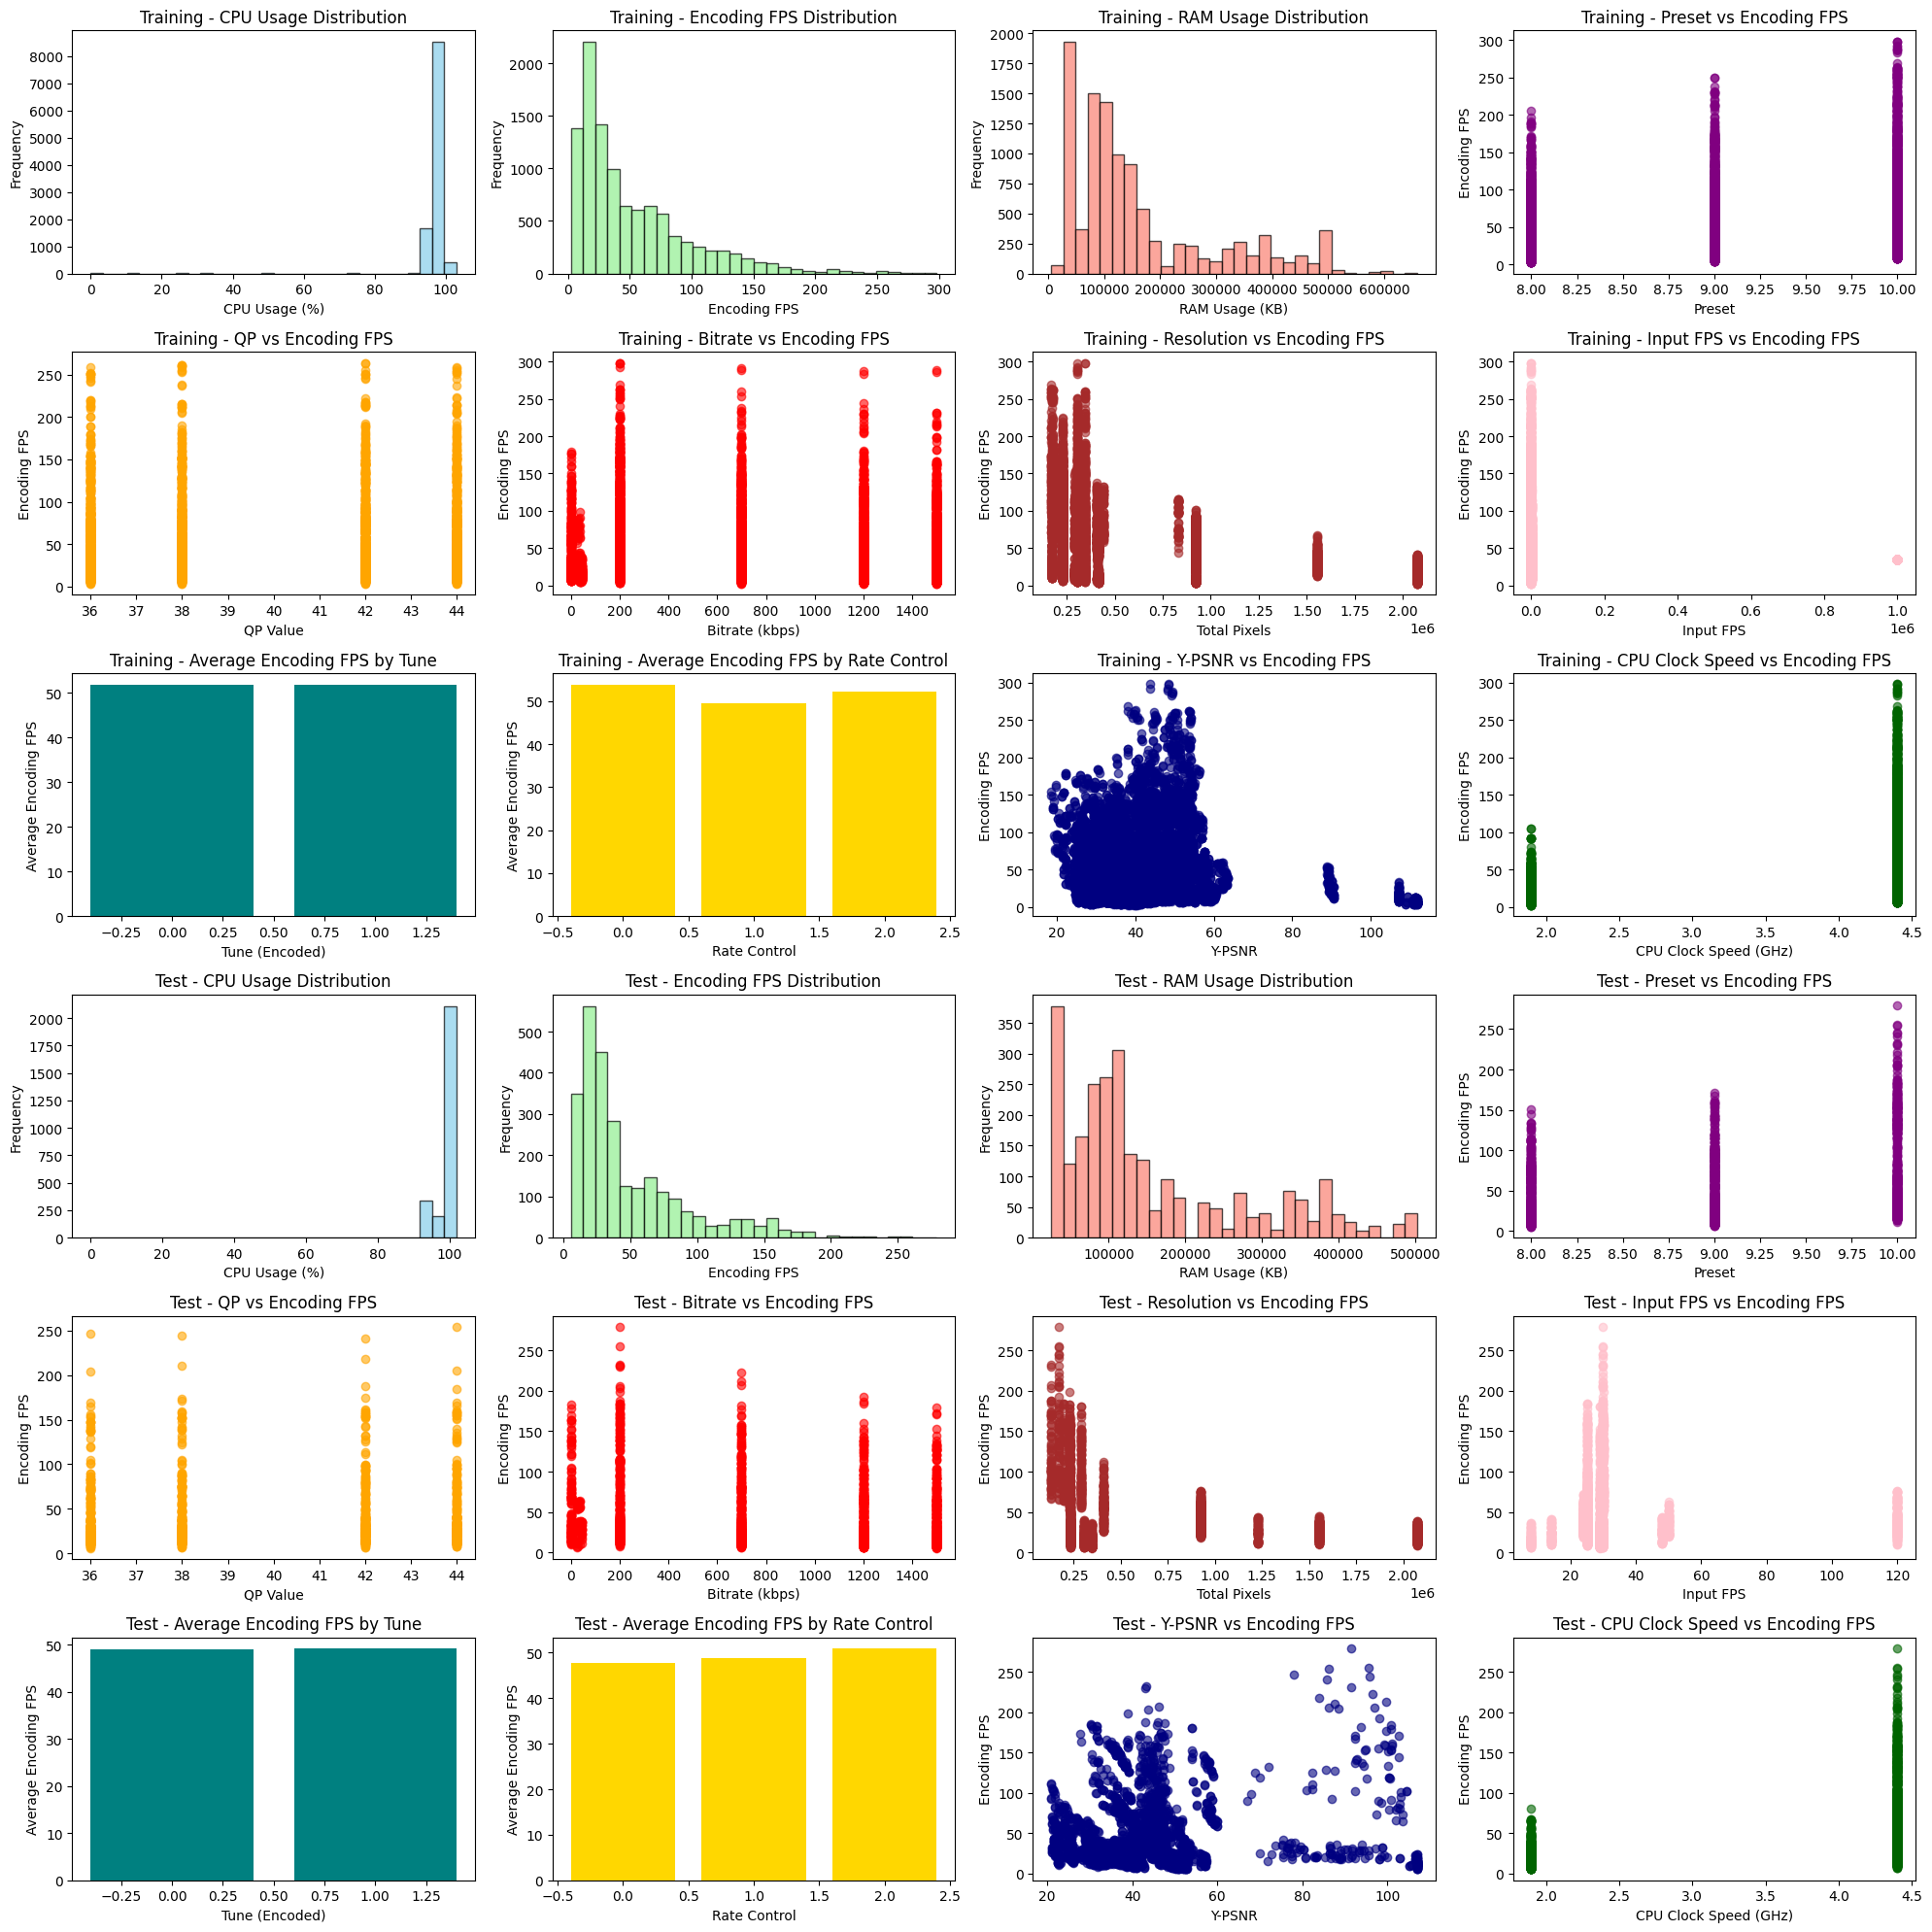

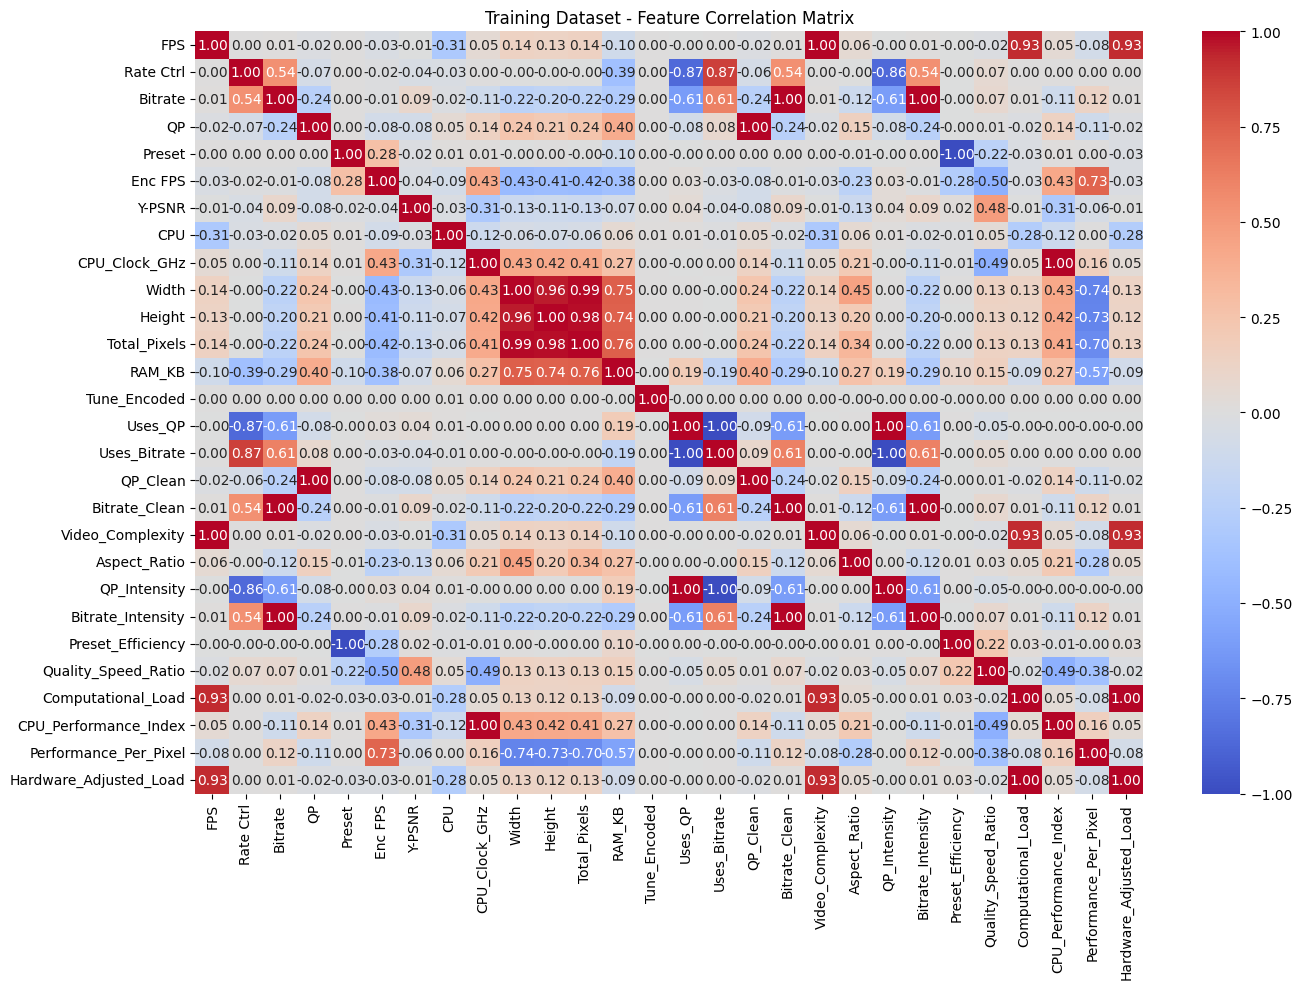

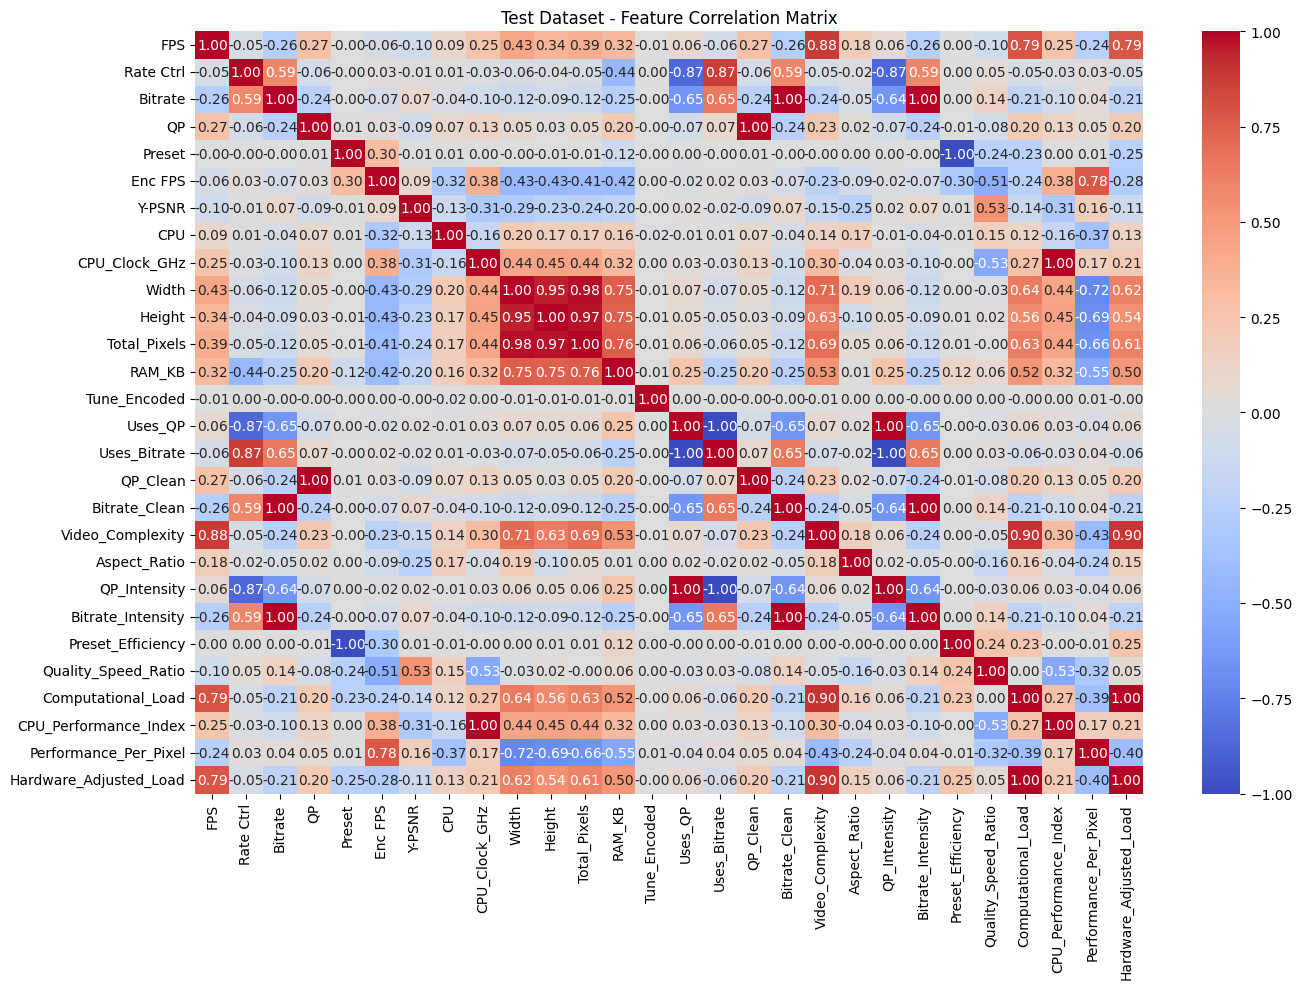


=== PREPARING MODEL DATA ===
Features: 25 columns
Targets: 3 columns
Feature columns: ['FPS', 'Rate Ctrl', 'Bitrate', 'QP', 'Preset', 'Y-PSNR', 'CPU_Clock_GHz', 'Width', 'Height', 'Total_Pixels', 'Tune_Encoded', 'Uses_QP', 'Uses_Bitrate', 'QP_Clean', 'Bitrate_Clean', 'Video_Complexity', 'Aspect_Ratio', 'QP_Intensity', 'Bitrate_Intensity', 'Preset_Efficiency', 'Quality_Speed_Ratio', 'Computational_Load', 'CPU_Performance_Index', 'Performance_Per_Pixel', 'Hardware_Adjusted_Load']
Training set: 8492 samples
Validation set: 2123 samples
Separate test set: 2648 samples

=== TRAINING MODELS ===

Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Training Linear Regression...

Training SVR...

=== MODEL EVALUATION ===

Model Performance Comparison:
                Model   Target  Train R²  Val R²       Val MSE     Val MAE  \
0       Random Forest      CPU    0.9303  0.4070  1.440020e+01      0.4931   
1       Random Forest  Enc FPS    0.9999  0.9996  8.961000e-01 

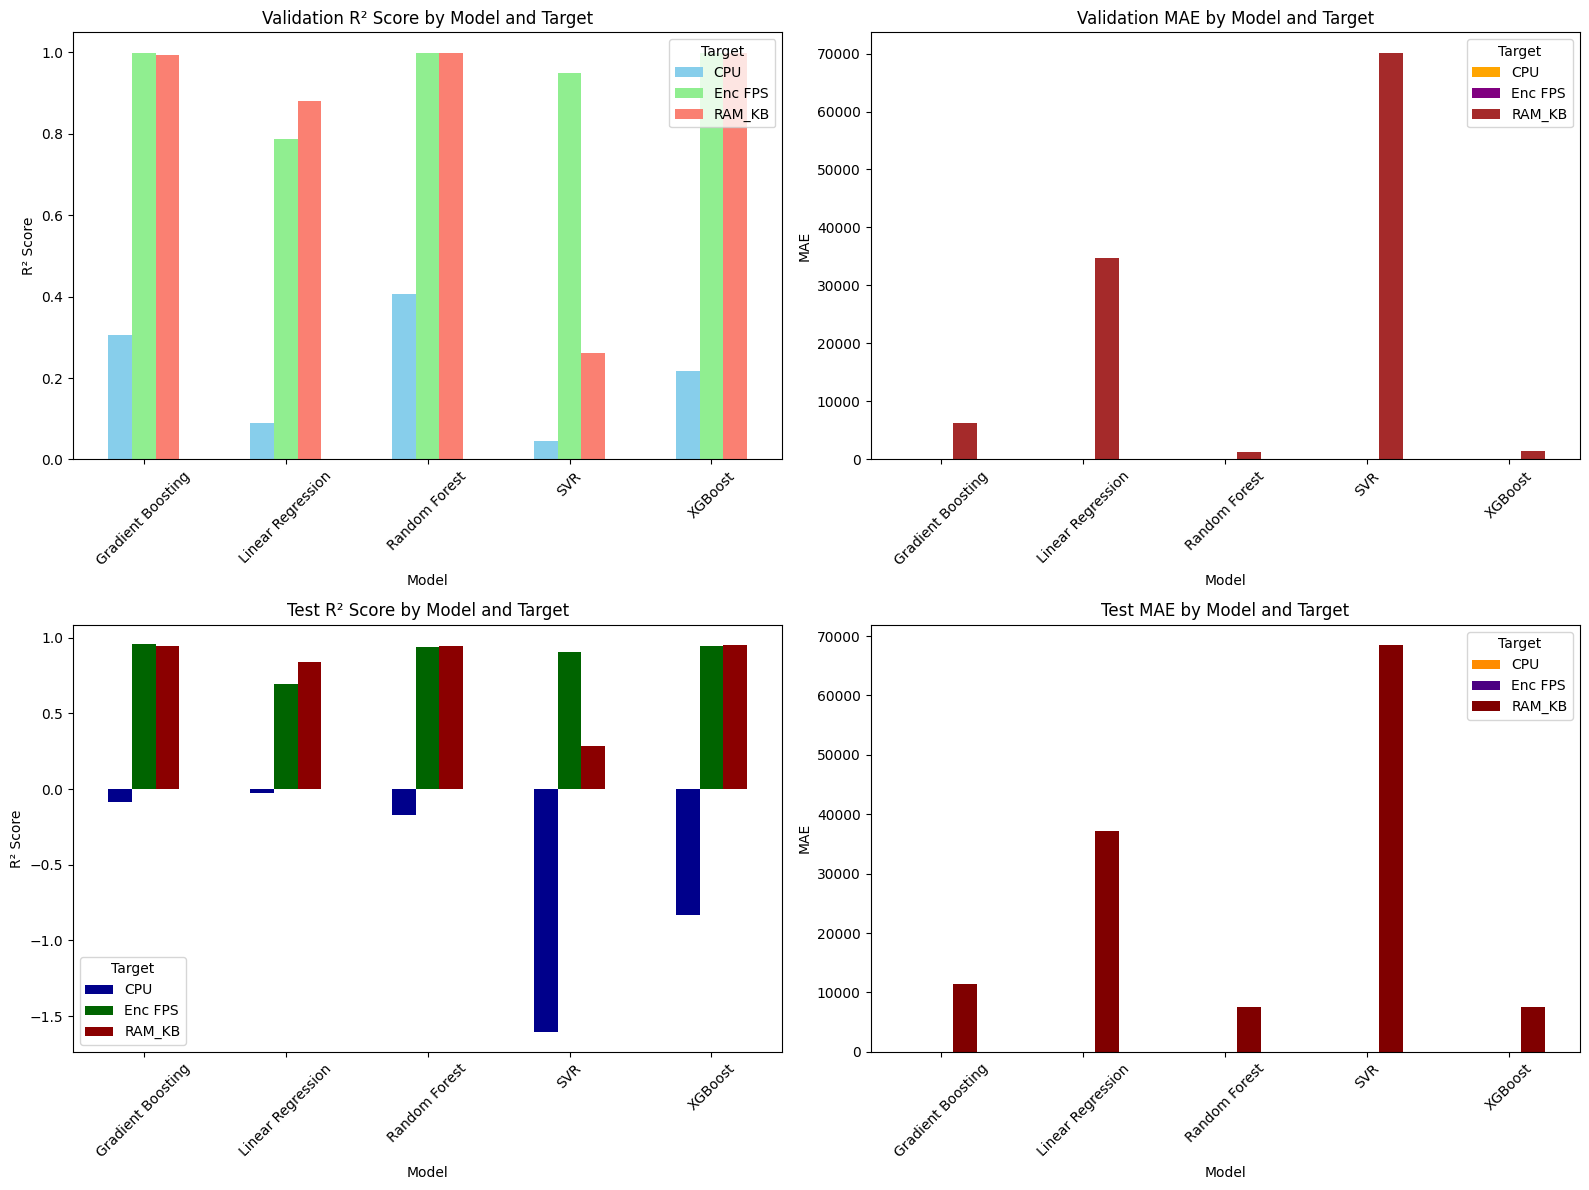


=== HYPERPARAMETER TUNING ===
Tuning Random Forest...
Random Forest - Best parameters: {'estimator__max_depth': None, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 100}
Random Forest - Best CV score: 0.7703

Tuning XGBoost...
XGBoost - Best parameters: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 6, 'estimator__n_estimators': 100}
XGBoost - Best CV score: 0.7572

Using Random Forest as final model (CV Score: 0.7703)

=== FINAL MODEL EVALUATION ===

Validation Set Performance:
  CPU: R² = 0.4165, MSE = 14.17, MAE = 0.53
  Enc FPS: R² = 0.9995, MSE = 1.06, MAE = 0.40
  RAM_KB: R² = 0.9990, MSE = 16998510.14, MAE = 1371.33

=== PLOTTING PREDICTIONS FOR VALIDATION SET ===


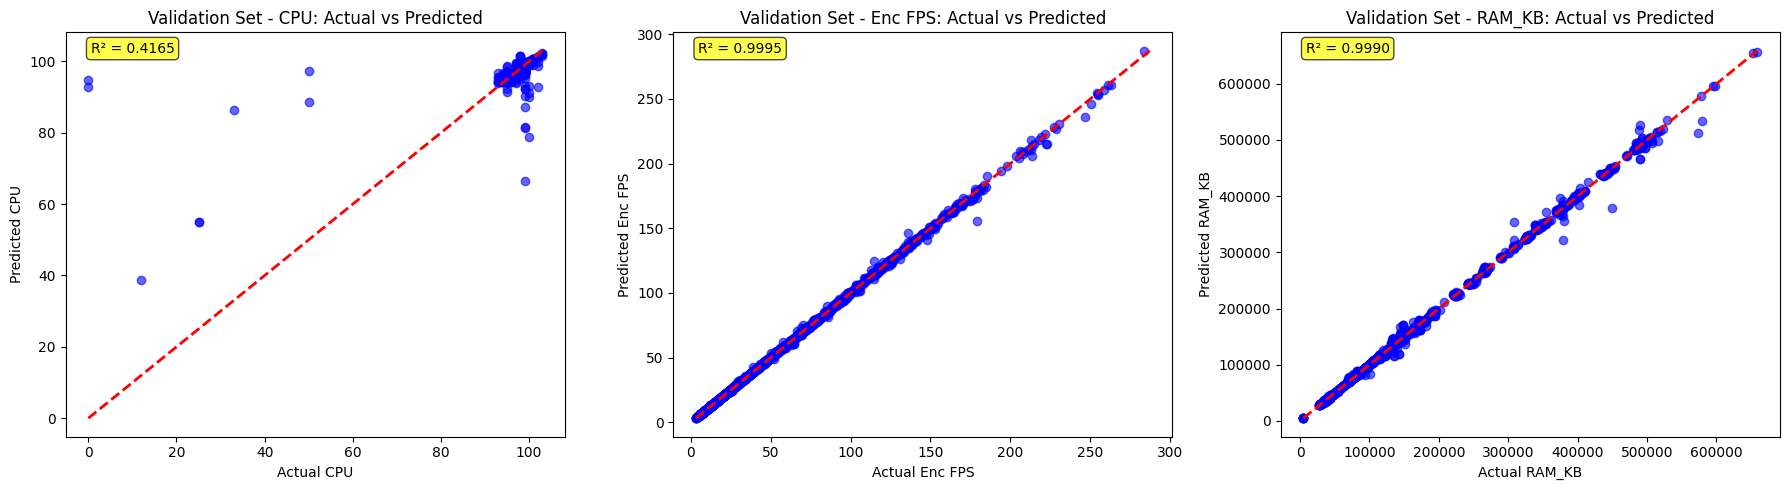


Separate Test Set Performance:
  CPU: R² = -0.1518, MSE = 6.82, MAE = 0.84
  Enc FPS: R² = 0.9368, MSE = 114.71, MAE = 2.52
  RAM_KB: R² = 0.9476, MSE = 778946789.29, MAE = 7623.83

=== PLOTTING PREDICTIONS FOR SEPARATE TEST SET ===


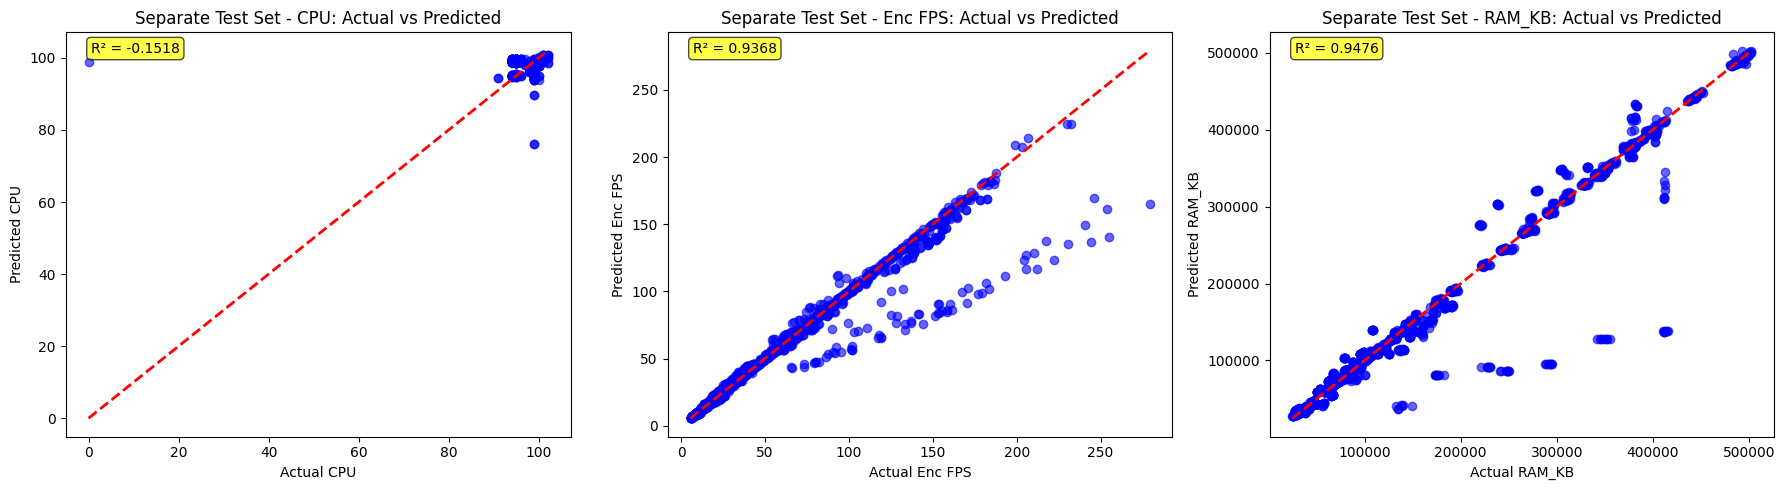


=== FEATURE IMPORTANCE ANALYSIS ===
Top 10 Most Important Features:
                   Feature  Importance
20     Quality_Speed_Ratio    0.436021
23   Performance_Per_Pixel    0.163751
1                Rate Ctrl    0.111754
5                   Y-PSNR    0.072898
15        Video_Complexity    0.025760
24  Hardware_Adjusted_Load    0.024614
9             Total_Pixels    0.019804
0                      FPS    0.019665
21      Computational_Load    0.018068
7                    Width    0.017948


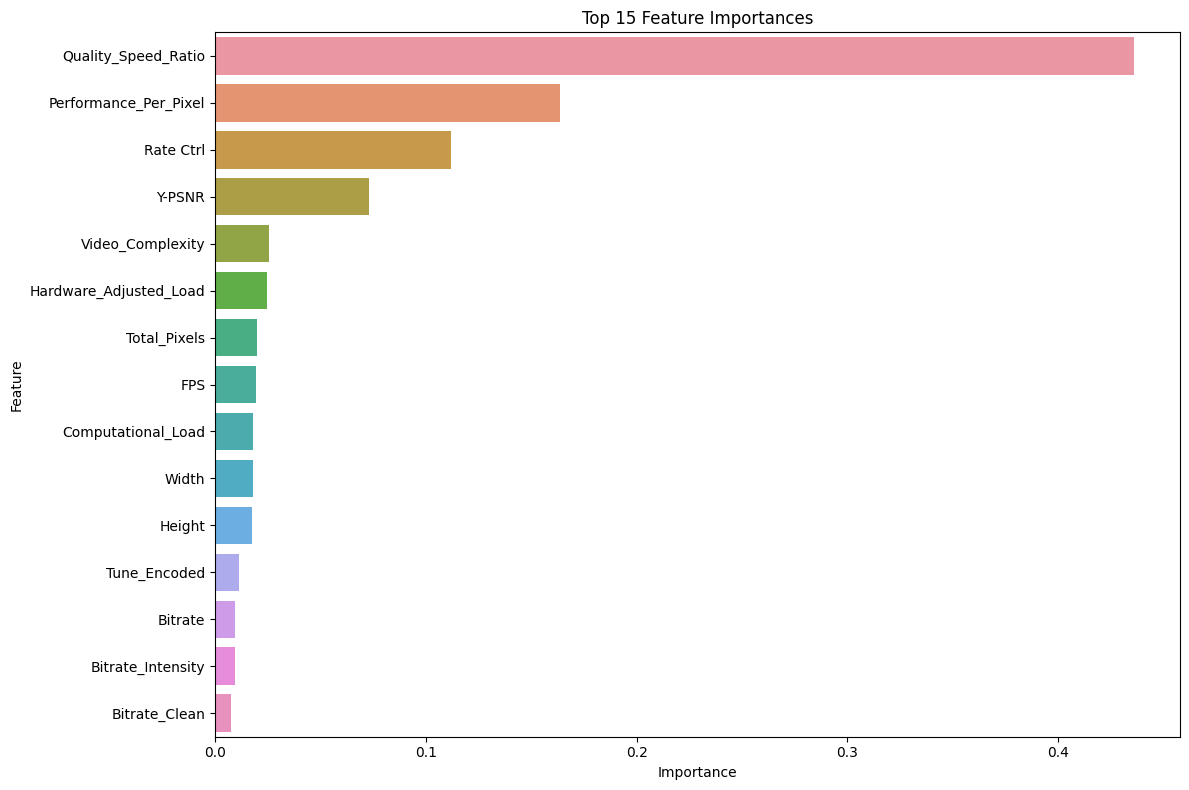


=== MAKING PREDICTIONS FOR NEW SETTINGS ===
Input Settings:
  Resolution: 1920x1080
  FPS: 30
  Bitrate: 1200 kbps
  Preset: 10
  Tune: visual_quality
  CPU Clock Speed: 3.2 GHz

Predicted Performance:
  CPU Usage: 98.5%
  Encoding FPS: 40.0
  RAM Usage: 441262 KB (430.9 MB)

=== ANALYSIS COMPLETE ===
Summary:
- Training samples: 10615
- Separate test samples: 2648
- Features used: 25
- Best model: RandomForestRegressor


In [6]:
# ============================================================================
# MODEL TRAINING AND EVALUATION
# ============================================================================

def prepare_model_data(df_train, df_test_separate=None):
    """
    Prepare features and targets for modeling
    """
    print("\n=== PREPARING MODEL DATA ===")
    
    # Define target variables
    targets = ['CPU', 'Enc FPS', 'RAM_KB']
    
    # Define feature columns (exclude targets)
    feature_cols = [col for col in df_train.columns if col not in targets]
    
    X_train_full = df_train[feature_cols]
    y_train_full = df_train[targets]
    
    # Split training data for internal validation
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
    
    # Prepare separate test data if provided
    X_test_separate = None
    y_test_separate = None
    if df_test_separate is not None:
        # Ensure test data has same features as training data
        missing_features = set(feature_cols) - set(df_test_separate.columns)
        if missing_features:
            print(f"Warning: Missing features in test data: {missing_features}")
            for feature in missing_features:
                df_test_separate[feature] = 0
        
        X_test_separate = df_test_separate[feature_cols]
        y_test_separate = df_test_separate[targets]
    
    print(f"Features: {len(feature_cols)} columns")
    print(f"Targets: {len(targets)} columns")
    print(f"Feature columns: {feature_cols}")
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    if X_test_separate is not None:
        print(f"Separate test set: {X_test_separate.shape[0]} samples")
    
    # Scale features - fit on training data only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_separate_scaled = None
    if X_test_separate is not None:
        X_test_separate_scaled = scaler.transform(X_test_separate)
    
    return (X_train_scaled, X_val_scaled, X_test_separate_scaled, 
            y_train, y_val, y_test_separate, scaler, feature_cols)

def train_models(X_train, X_val, X_test_separate, y_train, y_val, y_test_separate):
    """
    Train multiple models including XGBoost and compare performance
    """
    print("\n=== TRAINING MODELS ===")
    
    # Define models to test
    models = {
        'Random Forest': MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)),
        'Gradient Boosting': MultiOutputRegressor(GradientBoostingRegressor(n_estimators=200, random_state=42)),
        'XGBoost': MultiOutputRegressor(xgb.XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1)),
        'Linear Regression': MultiOutputRegressor(LinearRegression()),
        'SVR': MultiOutputRegressor(SVR(kernel='rbf', C=100, gamma='scale'))
    }
    
    results = {}
    target_names = ['CPU', 'Enc FPS', 'RAM_KB']
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on all available datasets
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        y_pred_test_separate = None
        if X_test_separate is not None:
            y_pred_test_separate = model.predict(X_test_separate)
        
        # Calculate metrics for each target
        results[name] = {'model': model}
        
        for i, target in enumerate(target_names):
            # Training metrics
            train_r2 = r2_score(y_train.iloc[:, i], y_pred_train[:, i])
            train_mse = mean_squared_error(y_train.iloc[:, i], y_pred_train[:, i])
            train_mae = mean_absolute_error(y_train.iloc[:, i], y_pred_train[:, i])
            
            # Validation metrics
            val_r2 = r2_score(y_val.iloc[:, i], y_pred_val[:, i])
            val_mse = mean_squared_error(y_val.iloc[:, i], y_pred_val[:, i])
            val_mae = mean_absolute_error(y_val.iloc[:, i], y_pred_val[:, i])
            
            results[name][target] = {
                'train_r2': train_r2,
                'train_mse': train_mse,
                'train_mae': train_mae,
                'val_r2': val_r2,
                'val_mse': val_mse,
                'val_mae': val_mae
            }
            
            # Separate test metrics if available
            if y_pred_test_separate is not None:
                test_r2 = r2_score(y_test_separate.iloc[:, i], y_pred_test_separate[:, i])
                test_mse = mean_squared_error(y_test_separate.iloc[:, i], y_pred_test_separate[:, i])
                test_mae = mean_absolute_error(y_test_separate.iloc[:, i], y_pred_test_separate[:, i])
                
                results[name][target].update({
                    'test_r2': test_r2,
                    'test_mse': test_mse,
                    'test_mae': test_mae
                })
        
        # Store predictions for visualization
        results[name]['y_pred_val'] = y_pred_val
        if y_pred_test_separate is not None:
            results[name]['y_pred_test_separate'] = y_pred_test_separate
    
    return results

def evaluate_models(results, has_separate_test=False):
    """
    Evaluate and compare model performance
    """
    print("\n=== MODEL EVALUATION ===")
    
    # Create comparison dataframe
    comparison_data = []
    for model_name, model_results in results.items():
        if model_name == 'model' or 'y_pred' in model_name:
            continue
        for target, metrics in model_results.items():
            if isinstance(metrics, dict) and 'train_r2' in metrics:
                row = {
                    'Model': model_name,
                    'Target': target,
                    'Train R²': metrics['train_r2'],
                    'Val R²': metrics['val_r2'],
                    'Val MSE': metrics['val_mse'],
                    'Val MAE': metrics['val_mae']
                }
                if has_separate_test and 'test_r2' in metrics:
                    row.update({
                        'Test R²': metrics['test_r2'],
                        'Test MSE': metrics['test_mse'],
                        'Test MAE': metrics['test_mae']
                    })
                comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Display results
    print("\nModel Performance Comparison:")
    print(comparison_df.round(4))
    
    # Find best model for each target based on validation R²
    print("\nBest Models by Target (based on Validation R²):")
    for target in ['CPU', 'Enc FPS', 'RAM_KB']:
        target_results = comparison_df[comparison_df['Target'] == target]
        best_model = target_results.loc[target_results['Val R²'].idxmax()]
        print(f"{target}: {best_model['Model']} (Val R² = {best_model['Val R²']:.4f})")
        if has_separate_test and 'Test R²' in best_model:
            print(f"         Test R² = {best_model['Test R²']:.4f}")
    
    return comparison_df

def hyperparameter_tuning(X_train, y_train):
    """
    Perform hyperparameter tuning for best performing models
    """
    print("\n=== HYPERPARAMETER TUNING ===")
    
    # Tuning for Random Forest
    print("Tuning Random Forest...")
    rf_param_grid = {
        'estimator__n_estimators': [100, 200, 300],
        'estimator__max_depth': [10, 20, None],
        'estimator__min_samples_split': [2, 5, 10]
    }
    
    rf_model = MultiOutputRegressor(RandomForestRegressor(random_state=42, n_jobs=-1))
    rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='r2', n_jobs=-1)
    rf_grid_search.fit(X_train, y_train)
    
    print(f"Random Forest - Best parameters: {rf_grid_search.best_params_}")
    print(f"Random Forest - Best CV score: {rf_grid_search.best_score_:.4f}")
    
    # Tuning for XGBoost
    print("\nTuning XGBoost...")
    xgb_param_grid = {
        'estimator__n_estimators': [100, 200],
        'estimator__max_depth': [3, 6, 9],
        'estimator__learning_rate': [0.01, 0.1, 0.2]
    }
    
    xgb_model = MultiOutputRegressor(xgb.XGBRegressor(random_state=42, n_jobs=-1))
    xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='r2', n_jobs=-1)
    xgb_grid_search.fit(X_train, y_train)
    
    print(f"XGBoost - Best parameters: {xgb_grid_search.best_params_}")
    print(f"XGBoost - Best CV score: {xgb_grid_search.best_score_:.4f}")
    
    # Return the better performing model
    if rf_grid_search.best_score_ > xgb_grid_search.best_score_:
        print(f"\nUsing Random Forest as final model (CV Score: {rf_grid_search.best_score_:.4f})")
        return rf_grid_search.best_estimator_
    else:
        print(f"\nUsing XGBoost as final model (CV Score: {xgb_grid_search.best_score_:.4f})")
        return xgb_grid_search.best_estimator_

def plot_predictions(y_true, y_pred, target_names, dataset_name=""):
    """
    Plot actual vs predicted values
    """
    print(f"\n=== PLOTTING PREDICTIONS FOR {dataset_name.upper()} ===")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, (target, ax) in enumerate(zip(target_names, axes)):
        # Scatter plot
        ax.scatter(y_true.iloc[:, i], y_pred[:, i], alpha=0.6, color='blue')
        
        # Perfect prediction line
        min_val = min(y_true.iloc[:, i].min(), y_pred[:, i].min())
        max_val = max(y_true.iloc[:, i].max(), y_pred[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        
        # Labels and title
        ax.set_xlabel(f'Actual {target}')
        ax.set_ylabel(f'Predicted {target}')
        ax.set_title(f'{dataset_name} - {target}: Actual vs Predicted')
        
        # R² score
        r2 = r2_score(y_true.iloc[:, i], y_pred[:, i])
        ax.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax.transAxes, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.tight_layout()
    plt.show()

def plot_model_comparison(comparison_df):
    """
    Plot model comparison charts
    """
    print("\n=== PLOTTING MODEL COMPARISON ===")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Validation R² comparison
    ax1 = axes[0, 0]
    pivot_val_r2 = comparison_df.pivot(index='Model', columns='Target', values='Val R²')
    pivot_val_r2.plot(kind='bar', ax=ax1, color=['skyblue', 'lightgreen', 'salmon'])
    ax1.set_title('Validation R² Score by Model and Target')
    ax1.set_ylabel('R² Score')
    ax1.legend(title='Target')
    ax1.tick_params(axis='x', rotation=45)
    
    # Validation MAE comparison
    ax2 = axes[0, 1]
    pivot_val_mae = comparison_df.pivot(index='Model', columns='Target', values='Val MAE')
    pivot_val_mae.plot(kind='bar', ax=ax2, color=['orange', 'purple', 'brown'])
    ax2.set_title('Validation MAE by Model and Target')
    ax2.set_ylabel('MAE')
    ax2.legend(title='Target')
    ax2.tick_params(axis='x', rotation=45)
    
    # Test R² comparison (if available)
    if 'Test R²' in comparison_df.columns:
        ax3 = axes[1, 0]
        pivot_test_r2 = comparison_df.pivot(index='Model', columns='Target', values='Test R²')
        pivot_test_r2.plot(kind='bar', ax=ax3, color=['darkblue', 'darkgreen', 'darkred'])
        ax3.set_title('Test R² Score by Model and Target')
        ax3.set_ylabel('R² Score')
        ax3.legend(title='Target')
        ax3.tick_params(axis='x', rotation=45)
        
        # Test MAE comparison
        ax4 = axes[1, 1]
        pivot_test_mae = comparison_df.pivot(index='Model', columns='Target', values='Test MAE')
        pivot_test_mae.plot(kind='bar', ax=ax4, color=['darkorange', 'indigo', 'maroon'])
        ax4.set_title('Test MAE by Model and Target')
        ax4.set_ylabel('MAE')
        ax4.legend(title='Target')
        ax4.tick_params(axis='x', rotation=45)
    else:
        # Hide unused subplots
        axes[1, 0].set_visible(False)
        axes[1, 1].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def predict_new_encoding(model, scaler, feature_cols, le_tune):
    """
    Make predictions for new encoding settings
    """
    print("\n=== MAKING PREDICTIONS FOR NEW SETTINGS ===")
    
    # Create sample input
    new_input = {
        'FPS': 30,
        'Rate Ctrl': 1,
        'Bitrate': 1200,
        'QP': -1,
        'Preset': 10,
        'Tune_Encoded': 1,
        'Width': 1920,
        'Height': 1080,
        'Total_Pixels': 1920 * 1080,
        'Uses_QP': 0,
        'Uses_Bitrate': 1,
        'QP_Clean': 0,
        'Bitrate_Clean': 1200,
        'Y-PSNR': 45.0,
        'CPU_Clock_GHz': 3.2,
        'Video_Complexity': 1920 * 1080 * 30,
        'Aspect_Ratio': 1920 / 1080,
        'QP_Intensity': 0,
        'Bitrate_Intensity': 1200,
        'Preset_Efficiency': 11 - 10,
        'Quality_Speed_Ratio': 45.0 / 40,
        'Computational_Load': (1920 * 1080 * 30 / 1000000) * 1,
        'CPU_Performance_Index': 3.2 * 1000,
        'Performance_Per_Pixel': 3.2 / (1920 * 1080 / 1000000),
        'Hardware_Adjusted_Load': ((1920 * 1080 * 30 / 1000000) * 1) / 3.2
    }
    
    # Convert to DataFrame
    new_df = pd.DataFrame([new_input])
    
    # Ensure all feature columns are present
    for col in feature_cols:
        if col not in new_df.columns:
            new_df[col] = 0
    
    # Reorder columns to match training data
    new_df = new_df[feature_cols]
    
    # Scale the input
    new_input_scaled = scaler.transform(new_df)
    
    # Make prediction
    prediction = model.predict(new_input_scaled)
    
    print("Input Settings:")
    print(f"  Resolution: 1920x1080")
    print(f"  FPS: 30")
    print(f"  Bitrate: 1200 kbps")
    print(f"  Preset: 10")
    print(f"  Tune: visual_quality")
    print(f"  CPU Clock Speed: 3.2 GHz")
    
    print("\nPredicted Performance:")
    print(f"  CPU Usage: {prediction[0][0]:.1f}%")
    print(f"  Encoding FPS: {prediction[0][1]:.1f}")
    print(f"  RAM Usage: {prediction[0][2]:.0f} KB ({prediction[0][2]/1024:.1f} MB)")
    
    return prediction

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """
    Main execution function
    """
    print("=== VIDEO ENCODING PERFORMANCE PREDICTION WITH SEPARATE TEST DATASET ===")
    
    # Load and preprocess data
    df_train_processed, df_test_processed, le_tune = preprocess_data(df_train, df_test_separate)
    
    # Feature engineering
    df_train_features, df_test_features = engineer_features(df_train_processed, df_test_processed)
    
    # Exploratory data analysis
    correlation_matrix = perform_eda(df_train_features, df_test_features)
    
    # Prepare model data
    (X_train, X_val, X_test_separate, y_train, y_val, y_test_separate, 
     scaler, feature_cols) = prepare_model_data(df_train_features, df_test_features)
    
    # Train models
    results = train_models(X_train, X_val, X_test_separate, y_train, y_val, y_test_separate)
    
    # Evaluate models
    has_separate_test = X_test_separate is not None
    comparison_df = evaluate_models(results, has_separate_test)
    
    # Plot model comparison
    plot_model_comparison(comparison_df)
    
    # Hyperparameter tuning for best models
    best_model = hyperparameter_tuning(X_train, y_train)
    
    # Final evaluation with best model
    print("\n=== FINAL MODEL EVALUATION ===")
    target_names = ['CPU', 'Enc FPS', 'RAM_KB']
    
    # Validation set evaluation
    val_pred = best_model.predict(X_val)
    print("\nValidation Set Performance:")
    for i, target in enumerate(target_names):
        r2 = r2_score(y_val.iloc[:, i], val_pred[:, i])
        mse = mean_squared_error(y_val.iloc[:, i], val_pred[:, i])
        mae = mean_absolute_error(y_val.iloc[:, i], val_pred[:, i])
        print(f"  {target}: R² = {r2:.4f}, MSE = {mse:.2f}, MAE = {mae:.2f}")
    
    # Plot validation predictions
    plot_predictions(y_val, val_pred, target_names, "Validation Set")
    
    # Separate test set evaluation (if available)
    if X_test_separate is not None and y_test_separate is not None:
        test_pred = best_model.predict(X_test_separate)
        print("\nSeparate Test Set Performance:")
        for i, target in enumerate(target_names):
            r2 = r2_score(y_test_separate.iloc[:, i], test_pred[:, i])
            mse = mean_squared_error(y_test_separate.iloc[:, i], test_pred[:, i])
            mae = mean_absolute_error(y_test_separate.iloc[:, i], test_pred[:, i])
            print(f"  {target}: R² = {r2:.4f}, MSE = {mse:.2f}, MAE = {mae:.2f}")
        
        # Plot separate test predictions
        plot_predictions(y_test_separate, test_pred, target_names, "Separate Test Set")
        
        # Feature importance analysis for separate test set
        if hasattr(best_model.estimators_[0], 'feature_importances_'):
            print("\n=== FEATURE IMPORTANCE ANALYSIS ===")
            
            # Get average feature importance across all targets
            feature_importance = np.mean([estimator.feature_importances_ for estimator in best_model.estimators_], axis=0)
            
            # Create feature importance dataframe
            importance_df = pd.DataFrame({
                'Feature': feature_cols,
                'Importance': feature_importance
            }).sort_values('Importance', ascending=False)
            
            print("Top 10 Most Important Features:")
            print(importance_df.head(10))
            
            # Plot feature importance
            plt.figure(figsize=(12, 8))
            sns.barplot(data=importance_df.head(15), y='Feature', x='Importance')
            plt.title('Top 15 Feature Importances')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.show()
    
    # Make prediction for new encoding settings
    predict_new_encoding(best_model, scaler, feature_cols, le_tune)
    
    print("\n=== ANALYSIS COMPLETE ===")
    print("Summary:")
    print(f"- Training samples: {len(df_train)}")
    if df_test_separate is not None:
        print(f"- Separate test samples: {len(df_test_separate)}")
    print(f"- Features used: {len(feature_cols)}")
    print(f"- Best model: {type(best_model.estimators_[0]).__name__}")
    
    return best_model, scaler, feature_cols, le_tune, comparison_df

# Run the complete pipeline
if __name__ == "__main__":
    best_model, scaler, feature_cols, le_tune, comparison_df = main()